## Проект: выбор локации для скважины

**Цель проекта:** на основании предсказаний модели машинного обучения выбрать регион для разработки скважины.

**Порядок выбора локации:**
- сбор характеристик для скважин: качество нефти и объём её запасов
- построение модели для предсказания объёма запасов в новых скважинах
- выбор скважин с самыми высокими оценками значений
- определение региона с максимальной суммарной прибылью отобранных скважин

**Вводные данные:** в нашем распоряжении есть данные о пробах нефти скважин в трёх регионах. Необходимо построить модель и определить регион, в котором добыча принесёт наибольшую прибыль.</br>
Данные содержат уникальный номер скважины, её характеристики и объем запасов в тыс. баррелей.</br>
</br>
Стоимость разработки скважины: 10 млрд. рублей.</br>
Стоимость барреля сырой нефти: 450 рублей.</br>

**План работы:**
- изучение и предобработка данных
- построение модели и получение предсказаний
- подготовка к расчёту прибыли
- расчёт прибыли и рисков

### Изучение и предобработка данных

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import pandas_profiling as pp
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import seaborn as sns

In [2]:
#зафиксируем константу random_state

RANDOM_STATE = 17

In [3]:
#откроем файл с данными

try:
    region_0 = pd.read_csv('datasets/geo_data_0.csv')
    region_1 = pd.read_csv('datasets/geo_data_1.csv')
    region_2 = pd.read_csv('datasets/geo_data_2.csv')
except FileNotFoundError:
    region_0 = pd.read_csv('/datasets/geo_data_0.csv')
    region_1 = pd.read_csv('/datasets/geo_data_1.csv')
    region_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим данные о каждом из трёх регионов

### Регион 0: изучение данных 

In [4]:
#общая инфоормация о данных

display(region_0.head(), region_0.info(), region_0.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


В датасете 100 000 записей, пропусков нет. Среднее значение запасов по региону - 92,5 тыс. баррелей с отклонением 44,2.

In [5]:
#проверим полные дубликаты

region_0.duplicated().sum()

0

In [6]:
#и уникальные значения

region_0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Здесь мы видим, что для 10 скважин имеется по 2 записи. Поскольку id каждой скважины уникален, двойная запись может означать ошибку. Найдем все записи с дублирующимися id и выведем на экран.

In [7]:
id_duplicated_0 = list(region_0[region_0['id'].duplicated() == True]['id'])
region_0.query('id == @id_duplicated_0').sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Под каждым уникальным id по две разные записи, которые по виду не выбиваются из общей массы. Возможно, измерения производились дважды и в датасете остались оба измерения, возможно, номер id был присвоен неверно. В любом случае, одна из этих записей не соответствует действительности - мы не знаем какая. Поэтому проще удалить все дубликаты по id, чтобы в обучение не попали ошибочные строки - по объему данных это составит сотые доли датасета.

In [8]:
region_0 = region_0.query('id != @id_duplicated_0')

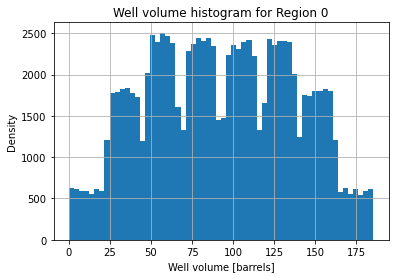

In [9]:
#выведем на экран распределение целевого признака и признаков

region_0['product'].hist(bins=60, grid=True);
plt.title('Well volume histogram for Region 0', fontsize=12)
plt.xlabel('Well volume [barrels]')
plt.ylabel('Density')
plt.show()

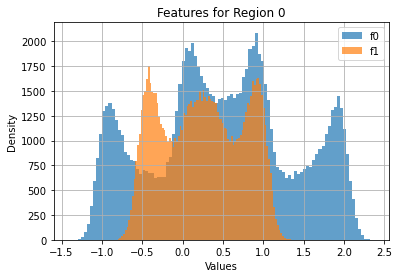

In [10]:
ax = region_0['f0'].hist(bins=100, alpha=0.7, legend=True);
region_0['f1'].hist(bins=100, alpha=0.7, legend=True);
plt.title('Features for Region 0', fontsize=12)
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

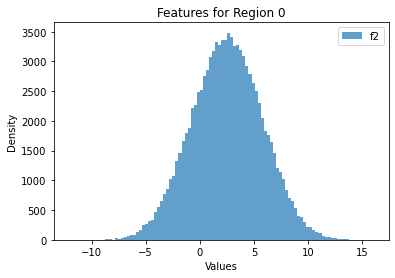

In [11]:
region_0['f2'].plot(kind='hist', bins=100, alpha=0.7, legend=True);
#region_0['f2'].plot(kind='density');
plt.title('Features for Region 0', fontsize=12)
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

Видим, что распределение, похожее на нормальное, имеет только один признак, f2, - вероятно, это какая-то природная, случайная характеристика, которую можно измерить в непрерывном диапазоне. Признаки f1 и f2 имеют достаточно специфический профиль с четко выраженными пиками - возможно, здесь мы видим суперпозицию нескольких распределений для разных видов скважин.</br>
Зубчатый профиль целевого признака связан, вероятно, с особенностями определения запасов и округления тех или иных измерений. Возможно, у разных типов скважин есть свой "характерный" запас и при отображении запаса всего региона мы также видим суперпозицию нескольких распределений.

In [12]:
#также посмотрим корреляцию

region_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003204,0.143504
f1,-0.440724,1.000000,0.001783,-0.192338
f2,-0.003204,0.001783,1.000000,0.483628
product,0.143504,-0.192338,0.483628,1.000000


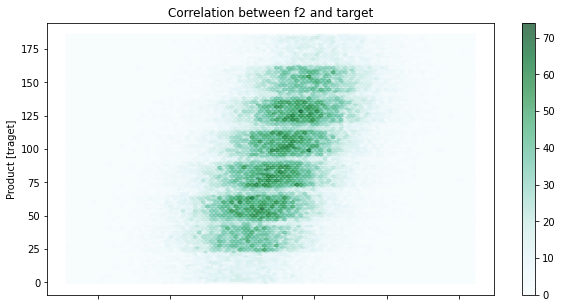

In [13]:
#и график корреляции между наиболее "сильным" признаком и целевым признаком

region_0.plot.hexbin(x='f2', y='product', alpha=0.7, figsize=(10,5));
plt.title('Correlation between f2 and target', fontsize=12)
plt.xlabel('f2')
plt.ylabel('Product [traget]')
plt.show()

Здесь заметны те же равномерные структуры, что и на гистограмме целевого признака. В реальной задаче стоило бы уточнить их происхождение - возможно, есть потеря части данных или предобработка, которая усложнит обучение модели в дальнейшем.</br>
Поскольку задача модельная, продолжаем анализировать as is :)

Сделаем то же самое для двух других регионов (включая удаление небольшого количества дубликатов неясной природы).

### Регион 1: изучение данных

In [14]:
#выведем на экран основную информацию

display(region_1.head(), region_1.info(), region_1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [15]:
#проверим полные дубликаты

region_1.duplicated().sum()

0

In [16]:
#проверим уникальные значения

region_1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [17]:
#выведем id с дубликатами, удалим их

id_duplicated_1 = list(region_1[region_1['id'].duplicated() == True]['id'])
region_1.query('id == @id_duplicated_1').sort_values(by='id')
region_1 = region_1.query('id != @id_duplicated_1')

При проверке уникальных значений оказалось, что у f2 всего 12 уникальных значений (хотя в предыдущем регионе это был признак с 100 000 уникальных значений и распределением, визуально близким к нормальному).</br>
Посмотрим ниже, как пробы распределены по этим значениям, построим гистограмму.

In [18]:
region_1.groupby('product')['id'].count()

product
0.000000      8235
3.179103      8336
26.953261     8468
30.132364     8306
53.906522     8472
57.085625     8388
80.859783     8319
84.038886     8430
107.813044    8200
110.992147    8302
134.766305    8303
137.945408    8233
Name: id, dtype: int64

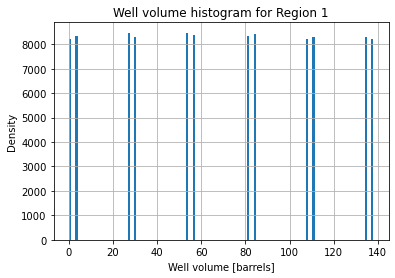

In [19]:
region_1['product'].hist(bins=140);
plt.title('Well volume histogram for Region 1', fontsize=12)
plt.xlabel('Well volume [barrels]')
plt.ylabel('Density')
plt.show()

Видим, что 12 значений разбиваются на 6 групп, близких друг к другу по величине, а все пробы распределены между этими группами равномерно. Возможно, речь идет о регионе с несколькими крупными месторождениями, вокруг которых и проводилась разведка. Возможно, при определении объема запасов была допущена ошибка и все данные были округлены к характерным средним значениям для разных видов месторождений (в предыдущем регионе мы уже видели нечто, похожее на суперпозицию пиков).
В любом случае, физический смысл таких данных в реальном проекте стоило бы уточнить.

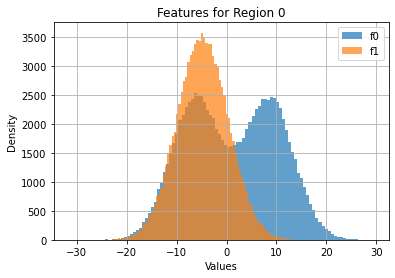

In [20]:
#посмотрим на гистограммы признаков

region_1['f0'].hist(bins=100, alpha=0.7, legend=True);
region_1['f1'].hist(bins=100, alpha=0.7, legend=True);
plt.title('Features for Region 0', fontsize=12)
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

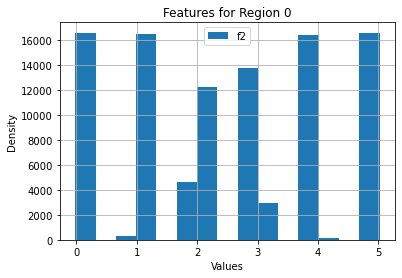

In [21]:
region_1['f2'].hist(bins=15, legend=True);
plt.title('Features for Region 0', fontsize=12)
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

Для f2 видим ту же структуру (но помним, что построена она на 100 000 уникальных значений). Разведка на одних и тех же точках? В любом случае стоило бы уточнить.

In [22]:
#смотрм корреляцию

region_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


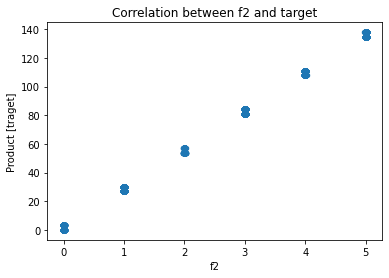

In [23]:
region_1.plot.scatter(x='f2', y='product');
plt.title('Correlation between f2 and target', fontsize=12)
plt.xlabel('f2')
plt.ylabel('Product [traget]')
plt.show()

Корреляция между признаком 'f2' и целевым признаком практически 100%. То есть признаки f0 и f1 фактически не будут задействованы в прогнозировании (мы сможем это посмотреть по коэффициентам линейной регрессии).

### Регион 2: изучение данных

In [24]:
display(region_2.head(), region_2.info(), region_2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [25]:
region_2.duplicated().sum()

0

In [26]:
region_2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [27]:
id_duplicated_2 = list(region_2[region_2['id'].duplicated() == True]['id'])
region_2.query('id == @id_duplicated_2').sort_values(by='id')
region_2 = region_2.query('id != @id_duplicated_2')

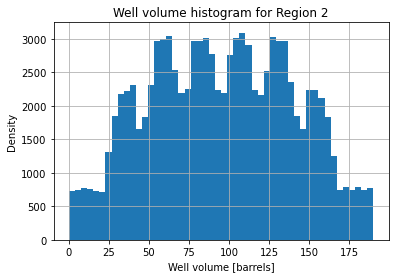

In [28]:
region_2['product'].hist(bins=50);
plt.title('Well volume histogram for Region 2', fontsize=12)
plt.xlabel('Well volume [barrels]')
plt.ylabel('Density')
plt.show()

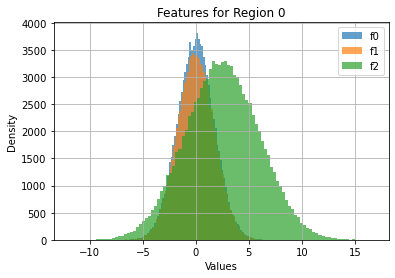

In [29]:
region_2['f0'].hist(bins=100, alpha=0.7, legend=True);
region_2['f1'].hist(bins=100, alpha=0.7, legend=True);
region_2['f2'].hist(bins=100, alpha=0.7, legend=True);
plt.title('Features for Region 0', fontsize=12)
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

In [30]:
region_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000501,-0.000454,-0.001974
f1,0.000501,1.000000,0.000763,-0.001046
f2,-0.000454,0.000763,1.000000,0.445873
product,-0.001974,-0.001046,0.445873,1.000000


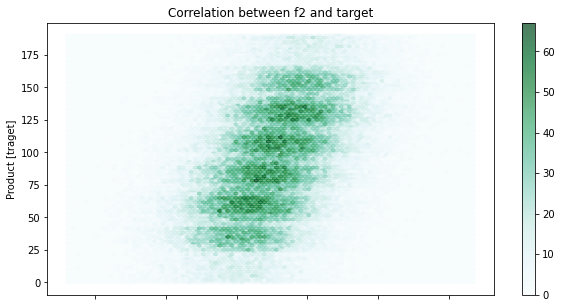

In [31]:
region_2.plot.hexbin(x='f2', y='product', alpha=0.7, figsize=(10,5));
plt.title('Correlation between f2 and target', fontsize=12)
plt.xlabel('f2')
plt.ylabel('Product [traget]')
plt.show()

### Выводы

Изучены данные с признаками и объемом запасов нефти в трёх регионах. </br>
Удалены дублирующие записи по id (менее 0,1% датасета).</br>
Изученные признаки имеют распределения, внешне похожие на нормальные или суперпозиции нормальных распределений.
Обнаружена особенность в данных по 'региону 1' - целевые признаки по всем 100 000 объектов дискретны равномерно распределены между 12ю значениями. Корреляция между признаком 'f2' (также имеет дискретный вид) и целевым признаком близка к 100%. Вероятно, требуется уточнение по данным.

## Построение моделей и получение предсказаний

По каждому из регионов разобьем данные на обучающую и валидационную выборки в соотношении 75/25, построим и обучим модель линейной регрессии и получим для нее предсказание.

In [51]:
#определим функцию, которая будет разбивать выборку, строить и обучать линейную регрессию, получать предсказания

def Linear_Regression_building(region_number):
    features = region_number[['f0', 'f1', 'f2']]
    target = region_number['product']
    features_train, features_valid, target_train, target_valid = (
        train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE))
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predict_mean = predictions.mean()
    #mean_squared_error = mean_squared_error(target_2_valid, predictions_2) ** 0.5
    print('Mean predicted volume, th.barrels:', predict_mean)
    print('RMSE, Linear Regression model:', mean_squared_error(target_valid, predictions) ** 0.5)
    print()
    print('Coefficients for Linear Regression model:')
    display(pd.DataFrame(model.coef_, features_train.columns, columns = ['Coeff']))
    return target_valid, predictions, predict_mean

### Region 0

In [52]:
target_0_valid, predictions_0, predict_mean_0 = Linear_Regression_building(region_0)

Mean predicted volume, th.barrels: 92.56856075898735
RMSE, Linear Regression model: 37.5486033580986

Coefficients for Linear Regression model:


,Coeff
f0,3.837242
f1,-13.940400
f2,6.616935


### Region 1

In [53]:
target_1_valid, predictions_1, predict_mean_1 = Linear_Regression_building(region_1)

Mean predicted volume, th.barrels: 68.86804950619829
RMSE, Linear Regression model: 0.8828723724611229

Coefficients for Linear Regression model:


,Coeff
f0,-0.144897
f1,-0.021606
f2,26.953619


### Region 2

In [54]:
print('Region 2')
target_2_valid, predictions_2, predict_mean_2 = Linear_Regression_building(region_2)

Region 2
Mean predicted volume, th.barrels: 95.0095878883643
RMSE, Linear Regression model: 40.06912587453392

Coefficients for Linear Regression model:


,Coeff
f0,-0.007808
f1,-0.080677
f2,5.717832


**Выводы:**
- построена и обучена модель Линейной Регрессии для каждого из трёх регионов
- получены предсказания по каждому из трёх регионов
- при сравнении со средним по выборке и по результатам предсказаний, видим, что модель достаточно точно предсказала это значение
- для региона 1 получено очень низкое значение RMSE - скорее всего, это связано с дискретностью данных
- из коэффициентов, полученных моделями, можем сказать, что для нулевогfо региона наиболее весомым является признак f1 (корреляция - обратная), для первого и второго - f2 (корреляция прямая). Для региона 1 вес коэффициента f2 существенно больше коэффициентов f0 и f1.

### Подготовка к расчету прибыли

In [56]:
#зададим переменные, пересчитав суммы в тыс. рублей

development_cost = 10000000
cost_per_1000_barr = 450
wells_number_for_explore = 500
wells_number_for_mining = 200

Посчитаем объем продукта, необходимый, чтобы окупить строительство скважины

In [57]:
product_value_needed = development_cost / cost_per_1000_barr
print(f'Product volume needed {product_value_needed:.0f} barrels')

Product volume needed 22222 barrels


Теперь на основании среднего рассчитаем объем продукта, который можно получить из 200 разрабатываемых точек в каждом регионе

In [58]:
product_value_predicted_0 = predict_mean_0 * wells_number_for_mining
print(f'In average, we can get {product_value_predicted_0:.0f} barrels from 200 points in region 0')

In average, we can get 18514 barrels from 200 points in region 0


In [59]:
product_value_predicted_1 = predict_mean_1 * wells_number_for_mining
print(f'In average, we can get {product_value_predicted_1:.0f} barrels from 200 points in region 1')

In average, we can get 13774 barrels from 200 points in region 1


In [60]:
product_value_predicted_2 = predict_mean_2 * wells_number_for_mining
print(f'In average, we can get {product_value_predicted_2:.0f} barrels from 200 points in region 2')

In average, we can get 19002 barrels from 200 points in region 2


**Вывод:** если в каждом из регионов выбрать 200 случайных скважин, средний предполагаемый объем сырья в них будет меньше объема, необходимого, чтобы покрыть расходы на добычу.

### Расчёт прибыли и рисков

Посчитаем прибыль, которую можно получить, если исследовать 500 случайных точек в регионе и выбрать 200 лучших.
Применим бутстреп, чтобы оценить среднюю прибыль и 95% доверительный интервал.

In [61]:
state=np.random.RandomState(RANDOM_STATE)

In [62]:
#определим функцию расчёта прибыли

def revenue_calc(target, predictions, num_for_explore, num_for_mining):
    targets_taken = target.reset_index(drop=True).sample(n=num_for_explore, replace=False, random_state=state)
    predictions_sorted = pd.Series(predictions)[targets_taken.index].sort_values(ascending=False)[:num_for_mining]
    #predictions_sorted = predictions_taken.sort_values(ascending=False)[:number_of_wells]
    product_value = targets_taken[predictions_sorted.index].sum()
    region_revenue = product_value * cost_per_1000_barr - development_cost
    return region_revenue

In [64]:
revenue_for_region_1 = revenue_calc(target_1_valid, predictions_1, wells_number_for_explore, wells_number_for_mining)
print(f'Revenue for region 1, calculated for 200 random potins: {revenue_for_region_1:.0f} th.RU')

Revenue for region 1, calculated for 200 random potins: 145166 th.RU


In [65]:
revenue_for_region_2 = revenue_calc(target_2_valid, predictions_2, wells_number_for_explore, wells_number_for_mining)
print(f'Revenue for region 2, calculated for 200 random potins: {revenue_for_region_2:.0f} th.RU')

Revenue for region 2, calculated for 200 random potins: 314034 th.RU


Как видим, с подсчётом прибыли для случайных точек всё хорошо: мы выбираем разведанных 500 скважин, отбираем 200 лучших и остаёмся в плюсе в каждом из трёх регионов. Однако выше мы видели, что средних значений запасов в регионе недостаточно, чтобы покрыть строительство и разработку - значит, существуют такие комбинации скважин, при которых мы не только не заработаем, но и уйдем в минус.</br>
Применим технику бутстреп на 1000 шагов, чтобы оценить риски для каждого из регионов.

In [66]:
#объявим функцию для бутстрепа

def bootstrap_1000(target, predictions, num_for_explore, num_for_mining):
    values = []
    for i in range(1000):
        revenue_subsample = revenue_calc(target, predictions, num_for_explore, num_for_mining)
        values.append(revenue_subsample)
    values = pd.Series(values)
    mean = values.mean()
    upper = values.quantile(0.975)
    lower = values.quantile(0.025)
    risks = st.percentileofscore(values, 0)
    return mean, upper, lower, risks    

In [67]:
#получим значения для первого региона

mean_0, upper_0, lower_0, risks_0 = bootstrap_1000(target_0_valid, predictions_0, wells_number_for_explore, wells_number_for_mining)

In [68]:
print(f'Average revenue for Region 0: {mean_0:.0f} th.RU. Confidence 95% interval: [{lower_0:.0f}, {upper_0:.0f}].')
print(f'Risk of getting negative revenue: {risks_0:.2f} %')

Average revenue for Region 0: 430532 th.RU. Confidence 95% interval: [-88947, 927450].
Risk of getting negative revenue: 5.20 %


In [69]:
mean_1, upper_1, lower_1, risks_1 = bootstrap_1000(target_1_valid, predictions_1, wells_number_for_explore, wells_number_for_mining)
print(f'Average revenue for Region 1: {mean_1:.0f} th.RU. Confidence 95% interval: [{lower_1:.0f}, {upper_1:.0f}].')
print(f'Risk of getting negative revenue: {risks_1:.2f} %')

Average revenue for Region 1: 456967 th.RU. Confidence 95% interval: [38154, 840119].
Risk of getting negative revenue: 1.40 %


In [73]:
mean_2, upper_2, lower_2, risks_2 = bootstrap_1000(target_2_valid, predictions_2, wells_number_for_explore, wells_number_for_mining)
print(f'Average revenue for Region 2: {mean_2:.0f} th.RU. Confidence 95% interval: [{lower_2:.0f}, {upper_2:.0f}].')
print(f'Risk of getting negative revenue: {risks_2:.2f} %')

Average revenue for Region 2: 408026 th.RU. Confidence 95% interval: [-143822, 915563].
Risk of getting negative revenue: 5.60 %


### Выводы: 

С 95% уверенностью мы можем утверждать, что при реализации аналогичной схемы отбора скважин, регион 1 окажется безубыточным для разработки. Средняя прибыль составит порядка 450 000 тыс. рублей, риск получения отрицательной прибыли - около 1%. Прибыль для регионов 0 и 2 может оказаться отрицательной с риском около 5% и 6% соответственно.

## Общий вывод

Были рассмотрены данные разведки трёх регионов, для каждого из них построена модель машинного обучения, получены средние значения запасов и прибыли от разработки региона, построен 95% доверительный интервал.</br>
Исходя из полученных результатов для разработки рекомендуется регион 1 - как единственный, где с 95% уверенностью мы можем утверждать, что разработка принесёт прибыль и не принесёт убытков.</br>
</br>
Однако, ввиду специфичности данных для региона 1 в реальной задаче следовало бы уточнить эти особенности и, возможно, применить другую модель для обучения - например модель небинарной классификации.</br>